# 딥러닝을 위한 고급 도구

## 케라스의 함수형 API
`Sequential` 모델은 네트워크 입력과 출력이 하나라고 가정  
-> 층을 차례대로 쌓아 구성


다양한 입력 소스에서 전달된 데이터를 다른 종류의 신경망 층을 사용해 처리해 합치는 경우도 있음  
-> 각 모델을 따로 훈련해, 각 예측을 가중 평균(weighted average)을 해 사용 (각 모델에서 추출한 정보가 중복된다면 최적의 방법은 아님)  

#### 최근 개발된 신경만 구조
선형적이지 않은 네트워크 토폴로지(topology)를 갖음  
- 인셉션(inception) 모듈
- 잔차 연결 추가 (ex. ResNet 계열)
  - 하위층(입력단)에서 학습된  정보가 데이터 처리 과정에서 손실되는 것을 방지

### 함수형 API 소개
함수형 API에서는 직접 텐서들의 입출력을 다룸  
-> 함수처럼 층을 이용해 텐서를 입력 받고출력

In [1]:
from tensorflow.keras import Input, layers

input_tensor = Input(shape=(32, )) # tensor
dense = layers.Dense(32, activation="relu") # 함수처럼 사용하기 위해 층 객체를 만듬

output_tensor = dense(input_tensor)

In [2]:
input_tensor

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'input_1')>

In [3]:
output_tensor

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense')>

#### Sequential 모델

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from  tensorflow.keras import Input

seq_model = Sequential()
seq_model.add(layers.Dense(32, activation="relu", input_shape=(64, )))
seq_model.add(layers.Dense(32, activation="relu"))
seq_model.add(layers.Dense(10, activation="softmax"))

seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


#### 함수형 API로 만든 모델

In [7]:
input_tensor = Input(shape=(64, ))
x = layers.Dense(32, activation="relu")(input_tensor)
x = layers.Dense(32, activation="relu")(x)
output_tensor = layers.Dense(10, activation="softmax")(x)

model = Model(input_tensor, output_tensor)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


### 다중 입력 모델
서로 다른 입력 가지를 합치기 위해 여러 텐서를 연결할 수 있는 층을 사용 (텐서를 더하거나 이어 붙이는 식)  
-> `keras.layers.add`, `keras.layers.concatenate` 등  

In [25]:
# 간단한 다중 입력 모델 (질문-응답 (question-anwering) 모델)
# input: 자연어 질문, 답변에 필요한 정보가 들어있는 텍스트
# output: 답변 (미리 정의한 어휘 사전에서 softmax 함수를 통핸 한 단어를 선택)

# 참고 텍스트 -> Embedding -> LSTM -> Concatenate -> Dense -> 응답
#   질문     -> Embedding -> LSTM

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# 참고 텍스트
text_input = Input(shape=(None, ), dtype="int32", name="text")
embedded_text = layers.Embedding(text_vocabulary_size, 64)(text_input)
encoded_text = layers.LSTM(32)(embedded_text)
# 질문
question_input = Input(shape=(None, ), dtype="int32", name="question")
embedded_question = layers.Embedding(question_vocabulary_size, 32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)
# 참고 텍스트와 질문 연결
concated = layers.concatenate([encoded_text, encoded_question], axis=-1)

answer = layers.Dense(answer_vocabulary_size, activation="softmax")(concated)

model= Model([text_input, question_input],  answer)

model.compile(
    optimizer="rmsprop",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)

#### 입력이 2개인 모델을 훈련 시키는 방법
1. 넘파이 배열 리스트 주입
2. 입력 이름과 넘파이 배열로 이뤄진  딕셔너리 (입력 이름을 설정한 경우)

In [26]:
# 데이터 생성
import numpy as np
from tensorflow.keras.utils import to_categorical

num_samples = 1000
max_length =100

text = np.random.randint(1, text_vocabulary_size, size=(num_samples, max_length))
question =np.random.randint(1, question_vocabulary_size, size=(num_samples, max_length))

answer = np.random.randint(0, answer_vocabulary_size, size=num_samples)

answer = to_categorical(answer)

In [24]:
# 1. 넘파이 배열 리스트 주입
with tf.device(":/GPU:0"):
    model.fit([text, question], answer, epochs=10, batch_size=128)

Epoch 1/10
8/8 [==============================] - 3s 82ms/step - loss: 6.2146 - acc: 0.0040
Epoch 2/10
8/8 [==============================] - 1s 81ms/step - loss: 6.1939 - acc: 0.0200
Epoch 3/10
8/8 [==============================] - 1s 75ms/step - loss: 6.1207 - acc: 0.0070
Epoch 4/10
8/8 [==============================] - 1s 78ms/step - loss: 6.0485 - acc: 0.0060
Epoch 5/10
8/8 [==============================] - 1s 75ms/step - loss: 5.9923 - acc: 0.0090
Epoch 6/10
8/8 [==============================] - 1s 85ms/step - loss: 5.9136 - acc: 0.0110
Epoch 7/10
8/8 [==============================] - 1s 76ms/step - loss: 5.8197 - acc: 0.0140
Epoch 8/10
8/8 [==============================] - 1s 75ms/step - loss: 5.7326 - acc: 0.0230
Epoch 9/10
8/8 [==============================] - 1s 80ms/step - loss: 5.6506 - acc: 0.0250
Epoch 10/10
8/8 [==============================] - 1s 80ms/step - loss: 5.5847 - acc: 0.0310


In [27]:
# 2. 딕셔너리 형식으로 주입
with tf.device(":/GPU:0"):
    model.fit({"text":text, "question":question}, answer, epochs=10, batch_size=128)

Epoch 1/10
8/8 [==============================] - 3s 79ms/step - loss: 6.2145 - acc: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 1s 86ms/step - loss: 6.1966 - acc: 0.0480
Epoch 3/10
8/8 [==============================] - 1s 84ms/step - loss: 6.1296 - acc: 0.0050
Epoch 4/10
8/8 [==============================] - 1s 81ms/step - loss: 6.0548 - acc: 0.0090
Epoch 5/10
8/8 [==============================] - 1s 85ms/step - loss: 5.9963 - acc: 0.0120
Epoch 6/10
8/8 [==============================] - 1s 78ms/step - loss: 5.9311 - acc: 0.0150
Epoch 7/10
8/8 [==============================] - 1s 80ms/step - loss: 5.8687 - acc: 0.0270
Epoch 8/10
8/8 [==============================] - 1s 91ms/step - loss: 5.7692 - acc: 0.0280
Epoch 9/10
8/8 [==============================] - 1s 78ms/step - loss: 5.6850 - acc: 0.0340
Epoch 10/10
8/8 [==============================] - 1s 77ms/step - loss: 5.6090 - acc: 0.0320


### 다중 출력 모델
다중 입력과 동일하게, 함수형 API를 사용하면 다중 출력 모델을 만들  수  있음  

In [28]:
# 데이터에 있는 여러 속성을 동시에 예측하는 네트워크
# 소셜 미디어의 익명 사용자의 포스트 -> 나이, 성별, 소득 수준  등을 예측
vocabulary_size = 50000
num_income_groups = 10

posts_input = Input(shape=(None, ), dtype="int32", name="posts")
embedded_posts = layers.Embedding(vocabulary_size, 256)(posts_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation="relu")(x)
x = layers.Conv1D(256, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation="relu")(x)
x = layers.Conv1D(256, 5, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)

age_pred = layers.Dense(1, name="age")(x)
income_pred = layers.Dense(num_income_groups, activation="softmax",name="income")(x)
gender_pred = layers.Dense(1, activation="sigmoid",  name="gender")(x)

model = Model(posts_input, [age_pred, income_pred, gender_pred])

네트워크 출력마다 다른 손실 함수를 지정해야 함 (리스트나 딕셔너리 형태로 지정)  
-> 경사 하강법은 하나의 스칼라 값을 최소화   
-> 모든 손실을 하나의 값으로 합쳐야 함  

In [29]:
# model.compile(
#     optimizer="rmsprop",
#     loss=[tf.keras.losses.mean_squared_error, tf.keras.losses.categorical_crossentropy, tf.keras.losses.binary_crossentropy]
# )

model.compile(
    optimizer="rmsprop",
    loss={
        "age" : tf.keras.losses.mean_squared_error,
        "income": tf.keras.losses.categorical_crossentropy,
        "gender" : tf.keras.losses.binary_crossentropy
    }
)

손실 값이 불균형하면 모델이 개별 손실이 가장 큰 작업에 치우쳐 표현을 최적화  
-> 다른 작업들은 손해를 입게 됨  
-> 손실 값이 최종 손실에 기여하는 수준을 지정할 수 있음

```python
model.compile(
    optimizer="rmsprop",
    loss=[tf.keras.losses.mean_squared_error, tf.keras.losses.categorical_crossentropy, tf.keras.losses.binary_crossentropy]
    loss_weights=[0.25, 1., 10.]
)

model.compile(
    optimizer="rmsprop",
    loss={
        "age" : tf.keras.losses.mean_squared_error,
        "income": tf.keras.losses.categorical_crossentropy,
        "gender" : tf.keras.losses.binary_crossentropy
    }
    loss_weigths={
        "age":0.25,
        "income":1.,
        "gender":10.
    }
)
```

In [ ]:
# 데이터 주입
# model.fit(posts, [age_targets, income_targets, gender_targets], epochs=10, batch_size=64) # 넘파이 배열

model.fit(posts, {"age":age_targets, "income":income_targets, "gender":gender_targets}, epochs=10, batch_size=64)

### 층으로  구성된 비순환 유향 그래프 (DAG, Directed Acyclic Graph)
함수형 API를 사용하면 내부 토폴로지가 복잡한 네트워크도 생성 가능  

#### 인셉션 모듈 (Inception)
합성곱 신경망에서 인기있는 네트워크 구조  
-> 네트워크 안의 네트워크(network-in-network)

3~4개의 가지를 갖음   
- 1X1 Conv -> 3X3 Conv 등
- 마지막에 전체 출력 특성이 합쳐짐
- 각 네트워크가 따로따로 공간 특성과 채널 방향의 특성을 학습

In [30]:
# Inception V3
# 입력(x)은 4D 텐서라고 가정
from keras import layers
# 모든 branch는 동일한 strides를 사용함 -> 출력의 크기를 동일하게 만들어 합치기 위해
branch_a = layers.Conv2D(128, 1, activation="relu", strides=2)(x)

branch_b = layers.Conv2D(128, 1, activation="relu")(x)
branch_b = layers.Conv2D(128, 3, activation="relu", strides=2)(branch_b)

branch_c = layers.AveragePooling2D(3, strides=2)(x)
branch_c = layers.Conv2D(128, 3, activation="relu")(branch_c)

branch_d = layers.Conv2D(128, 1, activation="relu")(x)
branch_d = layers.Conv2D(128, 3, activation="relu")(branch_d)
branch_d = layers.Conv2D(128, 3, activation="relu", strides=2)(branch_d)

output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

Inception V3 전체 구조는 케라시에 이미 준비되어 있으며, ImageNet 데이터셋에서 사전 훈련된 가주우치를 포함하고 있음  
Xception도 포함되어 있음  
- 인셉션에서 영감을 받은 합성곱 구조
- 채널 방향의 학습과  공간 방향의 학습을 극단적으로 분리해 깊이별로 분리

In [1]:
from keras.applications.inception_v3 import InceptionV3

InceptionV3

<function keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>

#### 잔차 연결(residual connection)
대규모 딥러닝 모델에서 흔히 나타나는 두 가지 문제를 해결  
1. 그래디언트 소실
2. 표현 병목(representational bottleneck)



일반적으로 10개 이상의 층을 갖는 모델에 잔차 연결을 추가하면 도움이 됨


잔차 연결은 하위층(입력에 가까운)의 출력을 상위층(출력에 가까운)의 입력으로 사용  
-> 순서대로 놓인 네트워크를 질러가는 연결이 만들어짐  
-> 하위층의 출력이 상위층의 활성화 출력에 더해짐 (두 출력의 크기가 동일해야하는 이유)  

In [ ]:
# 특성맵의 크기가 같은 경우, 원본을 그대로 사용하는 잔차 연결 예시
x = ... # 4D 텐서
y = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
y = layers.Conv2D(128, 3, activation="relu", padding="same")(y)
y = layers.Conv2D(128, 3, activation="relu", padding="same")(y)

y = layers.add([y, x]) # 원본 x를 출력 특성에 더함

In [ ]:
# 특성맵의 크기가 달라 선형 변환을 사용한 경우, 선형 변환을 사용하는 예시
x = ... # 4D 텐서
y = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
y = layers.Conv2D(128, 3, activation="relu", padding="same")(y)
y = layers.MaxPooling2D(2, strides=2)(y)

residual = layers.Conv2D(128, 1, strides=2, padding="same")(x) # y와 크기를 맞추기 위해 1x1 합성곱을 사용해 다운 샘플링

y = layers.add([y, residual])

#### 층 가중치 공유
함수형 API를 사용하면 층 객체를 여러 번 재사용 가능함  
-> 층 객체를 두 번 호출하면 새로운 층 객체를 만들지 않고 각 호출에 동일한 가중치를 재사용

두 문장 사이의 의미가 비슷한지 측정하는 모델  
-> 2개의 입력을 받고 0과 1 사이의 점수를 출력  
-> 대화 시스템(dialog system)에서 자연어 질의에 대한 중복 제거에서 유용하게 사용 가능  


의미가 비슷하다는 것은 대칭적인 관계이기 때문에, A에서 B의 유사도는 B에서 A의 유사도와 동일함  
-> 각 입력을 처리하는 2개의 독립된 모델을 학습하는건 이치에 맞지 않음  
-> 하나의 LSTM층으로 양쪽을 모두 처리 (샴 LSTM, 공유 LSTM)

In [ ]:
import tensorflow as tf
from keras import layers
from keras import Input
from keras.models import Model

lstm = layers.LSTM(32)

left_input = Input(shape=(None, 128))
left_output = lstm(left_input)

right_input = Input(shape=(None, 128))
right_output = lstm(right_input)

merged = layers.concatenate([left_output, right_output], axis=-1)
pred = layers.Dense(1, activation="sigmoid")(merged)

model = Model([left_input, right_input], pred)

model.fit([left_data, right_data], targets)

#### 층과 모델
함수형 API에서는 모델을 층처럼 사용할 수 있음  
-> 모델을 하나의 **커다란 층** 으로 생각  
-> 입력 텐서로 모델을 호출해 출력 텐서를 얻을 수 있음

In [ ]:
# 듀얼 카메라에서 입력을 받는 비전 모델
# 왼쪽 카메라와 오른쪽 카메라에서 시각적 특징을 추출하여 합칮기 위해 2개의 독립된 모델을 사용
from keras import layers
from keras import applications
from keras import Input

xception_base = applications.Xception(weights=None, include_top=False)

left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

left_features = xception_base(left_input)
right_features = xception_base(right_input)

merged_features = layers.concatenate(
    [left_features, right_features], axis=-1
)

## 콜백과 텐서보드
훈련하는 동안 모델 내부에서 일어나는 일을 조사하고 제어하는 방법  

### 콜백을 사용해 모델 훈련 과정 제어
- 모델 체크포인트 저장: 훈련 과정 중 어떤 지점에서 모델의 가중치를 저장
- 조기 종료(early stopping): 검증 손실이 더 이상 향상되지 않을 경우 훈련을 중지
- 하이퍼파라미터 값을 동적으로 조정: ex. 옵티마이저의 학습률
- 훈련과 검증 지표를 로그에 기록하거나 시각화

```python
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
...
```

#### ModelCheckpoint와 EarlyStopping 콜백

In [ ]:
import keras

callbacks_list = [ # fit() 메서드의 callbacks 매개변수를 사용해 콜백의 리스트를 모델로 전달
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=1
    )
    keras.callbacks.ModelCheckpoint(
        filepath="my_model.h5", # 모델 파일의 경로
        monitor="val_loss", # val_loss가 좋아지는 경우에는 체크포인트를 저장
        save_best_only=True
    )
]

#### ReduceLROnPlateau 콜백
검증 손실이 향상되지 않을 때 학습률을 작게 할 수 있음  
-> 손실 곡선이 평탄할 때, 학습률을 작게 하거나 크게 하면 훈련 도중 지역 최솟값에서 효과적으로 빠져나올 수 있음

In [ ]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1, # 콜백 실행시, 학습률을 10배로 줄임
        patience=10 # 검증 손실이 10 에포크 동안 좋아지지 않으면 콜백이 호출
    )
]

#### 커스텀 콜백
내장 콜백에서 제공하지 않는 특수한 행동이 훈련 도중 필요하면 커스텀 콜백을 만들 수 있음  
-> Callback 클래스를 상속 받아 구현

`logs` 매개변수와 함께 호출되며, 이 매개변수는 이전 배치, 에포크에 대한 훈련과 ㅓㅁ증 측정값이 담겨 있는 딕셔너리가 전달 됨

In [ ]:
import keras
import numpy as np

class CustomCallbacks(keras.callbacks.Callback):
    def set_model(self, model):
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        self.activation_model = keras.models.Model(model.input, layer_outputs) # 각 층의 활성화 출력을 반환하는 Model 객체

    def on_epoch_end(self, epoch, logs=None): # 각 에포크가 끝나면 호출하는 콜백
        if self.validation_data is None:
            raise RuntimeError("Requires validation_data.")
        validation_sample = self.validation_data[0][0:1] # 검증 데이터의 첫 번째를 샘플로 가져옴
        activations = self.activation_model.predict(validation_sample)
        f = open("activations_at_epoch_"+str(epoch)+".npz", "wb")
        np.save(f, activations)
        f.close()

### 텐서보드
텐서보드의 핵심 목적은 훈련 모델의 내부에서 일어나는 모든 것을 시각적으로 모니터링할 수 있도록 돕는 것  
- 훈련하는 동안 측정 지표를 시각적으로 모니터링
- 모델 구조를 시각화
- 활성화 출력과 그래디언트의 히스토그램 시각화
- 3D로 임베딩을 표현

In [1]:
# IMDN 감성 분석 문제를 위한 1D 컨브넷 훈련
import tensorflow as tf
import keras
from keras import layers
from keras.datasets import imdb
from keras.utils import pad_sequences

max_features = 2000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [2]:
model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len, name="embed"))
model.add(layers.Conv1D(32, 7, activation="relu"))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation="relu"))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed (Embedding)           (None, 500, 128)          256000    
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 3

In [3]:
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["acc"]
)

In [4]:
import os
# 텐서보드 로그 파일을 위한 디렉토리 생성
if not os.path.exists("./my_log_dir"):
    os.mkdir("./my_log_dir")

In [5]:
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir="./my_log_dir",
        histogram_freq=1, # 1 에포크마다 활성화 출력의 히스토그램을 기록
        embeddings_freq=1, # 1 에포크마다 임베딩 데이터를 기록
    )
]

with tf.device(":/GPU:0"):
    history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 14s 88ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 2/20
157/157 [==============================] - 13s 86ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 3/20
157/157 [==============================] - 18s 118ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 4/20
157/157 [==============================] - 18s 112ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 5/20
157/157 [==============================] - 18s 112ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 6/20
157/157 [==============================] - 16s 100ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 7/20
157/157 [==============================] - 14s 90ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 8/20
157/157 [==============================] - 18s 

In [12]:
!tensorboard --logdir=my_log_dir

^C


`localhost:6006`에 접속하면 모델의 훈련 결과를 확인할 수 있음  

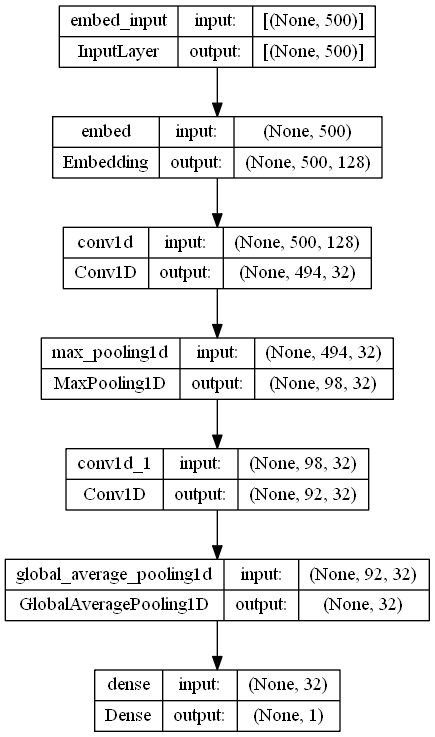

In [7]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file="model.png")

## 모델 튜닝: 성능 올리기
### 고급 구조 패턴
#### 배치 정규화
정규화(normalization)는 머신 러닝 모델에 주입되는 샘플들을 균일하게 만드는 광범위한 방법  
-> 모델이 학습하고 새로운 데이터에 잘 일반화되도록 도움  
-> 데이터에서 평균을 빼서 데이터를 원점에 맞춰 표준 편차로 나누어 데이터의 분산을 1로 만듬  
-> 데이터 정규화는 네트워크에서 일어나는 모든 변환 후에도 고려되어야 함  



배치 정규화(batch normalization)는 층의 한 종류임  
-> 훈련하는 동안 평균과 분산이 바뀌더라도 이에 적응하여 데이터를 정규화  
-> 훈련 과정에 사용된 배치 데이터의 평균과 분산에 대한 지수 이동 평균(exponential moving average)을 내부에 유지  
-> 일반적으로 합성곱이나 완전 연결층 다음에 사용  
-> 정규화할 특성 축을 지정하는 `axis` 매개변수가 있음 (`default=-1`: 입력 텐서의 마지막 축)

In [ ]:
conv_model.add(layers.Conv2D(32, 3, activation="relu"))
conv_model.add(layers.BatchNormalization())

dense_model.add(layers.Dense(32, activation="relu"))
dense_model.add(layers.BatchNormalization())

#### 깊이별 분리 합성곱(depthwise separable convolution)
`Conv2D`를 대체하면서 더 가볍고 더 빨라 모델의 성능을 몇 퍼센트 포인트 높일 수 있는 층  
-> 입력 채널별로 따로따로 공간 방향의 합성곱을 수행, 이후 점별 합성곱(1X1 합성곱)을 통해 출력 채널을 합침  
-> 공간 특성의 학습과 채널 방향 특성의 학습을 분리하는 효과 (입력에서 공간상 위치는 상관관계가 크지만 채널별로는 독립적이라고 가정시 타당)  
-> 모델 파라미터와 연산의 수를 크게 줄여 주기 때문에 적은 데이터로도 더 좋은 표현을 학습하고 성능이 높은 모델을 만듬  
-> 제한된 데이터로 작은 모델을 처음부터 훈련시킬 때 중요

In [2]:
# 작은 데이터셋에서 이미지 분류 문제 (소프트맥스 분류)를 위한 가변운 깊이별 분리 컨브넷
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

height = 64
width = 64
channels = 3
num_class = 10

model = Sequential()
model.add(layers.SeparableConv2D(32, 3, activation="relu", input_shape=(height, width, channels,)))
model.add(layers.SeparableConv2D(64, 3, activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation="relu"))
model.add(layers.SeparableConv2D(128, 3, activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation="relu"))
model.add(layers.SeparableConv2D(128, 3, activation="relu"))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(num_class, activation="softmax"))

model.compile(
    optimizer="rmsprop",
    loss=tf.keras.losses.CategoricalCrossentropy()
)

### 하이퍼파라미터 최적화
가능한 결정 공간을 자동적, 조직적, 규칙적 방법으로 탐색해야 함  
1. 일련의 하이퍼파라미터를 (자동으로) 선택
2. 선택된 하이퍼파라미터로 모델 생성
3. 훈련 데이터에 학습하고 검증 데이터에서 최종 성능을 측정
4. 다음으로 시도할 하이퍼파라미터를 (자동으로) 선택
5. 위 과정 반복
6. 마지막으로 테스트 데이터에서 성능을 측정


주어진 하이퍼파라미터에서 얻은 검증 성능을 사용하여 다음 번에 시도할 하이퍼파라미터를 선택하는 알고리즘이 과정의 핵심  
-> 베이지안 최적화(bayesian optimization), 유전 알고리즘(genetic algorithms), 랜덤 탐색(random search) ...  
-> 모델의 가중치를 훈련하는 것은 쉽지만, 하이퍼파라미터를 업데이트하는 것은 어려움

해당 분야는 아직 초창기임

### 모델 앙상블 (model ensemble)
여러 개 다른 모델의 예측을 합쳐서 더 좋은 예측을 만듬  
-> 독집적으로 훈련된 다른 종류의 모델이 각기 다른 장점을 갖고 있다는 가정이 바탕  

In [ ]:
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)

In [ ]:
final_preds = 0.5*preds_a + 0.25*preds_b + 0.1*preds_c + 0.15*preds_d